In [1]:
import numpy as np
from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient, OperatorStateFn
from qiskit.utils import QuantumInstance
import matplotlib.pyplot as plt
import sys, os
sys.path.insert(0, os.path.join("..", "..","src"))
from qiskit_utils import BinaryObjectiveFunction
from data_utils import circle, plot_data, generate_ds

# Set a random seed
np.random.seed(42)

In [2]:
# Generate training and test data
num_training = 200
num_test = 2000

X_train, y_train, new_y_train = generate_ds(num_training)
X_test, y_test, new_y_test= generate_ds(num_test)

In [3]:
# set method to calculcate expected values
expval = AerPauliExpectation()

# define gradient method
gradient = Gradient()

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

In [5]:
from qiskit_machine_learning.neural_networks import OpflowQNN

inputs = ParameterVector('input', length=4) # 1 extra for label
# inputs = ParameterVector('input', length=3)
weights = ParameterVector('weight', length=13)

# 1qubit classifier
qc1 = QuantumCircuit(1)
qc1.u(weights[10],weights[11],weights[12],0)
qc1.rz(inputs[0]*weights[0]+inputs[1]*weights[1]+inputs[2]*weights[2] + weights[3],0)
qc1.ry(weights[4],0)
qc1.rz(inputs[0]*weights[5]+inputs[1]*weights[6]+inputs[2]*weights[7] + weights[8],0)
qc1.ry(weights[9],0)
qc_sfn1 = StateFn(qc1)

H1 = StateFn(PauliSumOp.from_list([('Z', 1.0)]))  
H2 = StateFn(PauliSumOp.from_list([('Z', -1.0)]))  

op1 = ~H1 @ (qc_sfn1)
op2 = ~H2 @ (qc_sfn1)
print(op1)
print(len(weights))

ComposedOp([
  OperatorMeasurement(1.0 * Z),
  CircuitStateFn(
       ┌─────────────────────────────────────┐»
  q_0: ┤ U(weight[10],weight[11],weight[12]) ├»
       └─────────────────────────────────────┘»
  «     ┌──────────────────────────────────────────────────────────────────────────────┐»
  «q_0: ┤ Rz(input[0]*weight[0] + input[1]*weight[1] + input[2]*weight[2] + weight[3]) ├»
  «     └──────────────────────────────────────────────────────────────────────────────┘»
  «     ┌───────────────┐»
  «q_0: ┤ Ry(weight[4]) ├»
  «     └───────────────┘»
  «     ┌──────────────────────────────────────────────────────────────────────────────┐»
  «q_0: ┤ Rz(input[0]*weight[5] + input[1]*weight[6] + input[2]*weight[7] + weight[8]) ├»
  «     └──────────────────────────────────────────────────────────────────────────────┘»
  «     ┌───────────────┐
  «q_0: ┤ Ry(weight[9]) ├
  «     └───────────────┘
  )
])
13


In [6]:
# construct OpflowQNN with the operator, the input parameters, the weight parameters,
# the expected value, gradient, and quantum instance.
qnn1 = OpflowQNN(op1, inputs, weights, expval, gradient, qi_sv, input_gradients=True)
qnn2 = OpflowQNN(op2, inputs, weights, expval, gradient, qi_sv, input_gradients=True)

In [7]:
from qiskit.algorithms.optimizers import ADAM, L_BFGS_B
from qiskit_machine_learning.utils.loss_functions import L2Loss
from qiskit.utils import algorithm_globals

losses = []
def callback_fn(avg_loss, weights):
    print("weights: ", weights)
    print("loss: ", avg_loss)
    losses.append(avg_loss)

function = BinaryObjectiveFunction(X_train, new_y_train, qnn1, qnn2, L2Loss(), callback_fn)

In [20]:
losses = []
# optimizer = ADAM(maxiter=30, lr=0.8)
optimizer = L_BFGS_B(maxiter=50)
# fit_result = optimizer.minimize(
fit_result = optimizer.optimize(
    num_vars=qnn1.num_weights,
    objective_function=function.objective,
    initial_point=algorithm_globals.random.random(qnn1.num_weights),
    gradient_function=function.gradient,
)

<bound method BinaryObjectiveFunction.gradient of <__main__.BinaryObjectiveFunction object at 0x00000182185FAC40>>
weights:  [0.6317096  0.85042907 0.3870059  0.64812163 0.15726497 0.0785668
 0.3023903  0.50227641 0.56396782 0.28585151 0.53360247 0.21369987
 0.41107819]
loss:  1.6521039542263751
weights:  [0.58141182 0.82427565 0.3870059  0.49733866 0.77669277 0.04820942
 0.29021063 0.50227641 0.44224552 0.69526943 1.15337264 0.0629169
 0.41107819]
loss:  1.2934928293195802
weights:  [0.54905108 0.78193903 0.3870059  0.62097778 0.61738945 0.02441236
 0.25948637 0.50227641 0.54112826 0.58008024 0.99400282 0.18655602
 0.41107819]
loss:  1.1113714022393195
weights:  [ 0.46442669  0.6942346   0.3870059   0.62998798  0.56624572 -0.03035666
  0.20218173  0.50227641  0.55672349  0.5101917   0.91549105  0.19556622
  0.41107819]
loss:  1.074580908434862
weights:  [ 0.3070586   0.53508128  0.3870059   0.59858298  0.58336022 -0.12818432
  0.10216945  0.50227641  0.54904424  0.45985209  0.87766744

loss:  0.6502879040875083
weights:  [ 0.01354501 -0.90295808  0.3870059   0.32361363  2.4509421  -0.09297829
  1.87008717  0.50227641 -0.0392313   1.31033391  1.69475188 -0.11080813
  0.41107819]
loss:  0.6502717155796204
weights:  [ 0.01220475 -0.90401706  0.3870059   0.32392498  2.45113937 -0.09275734
  1.87024953  0.50227641 -0.03886123  1.30780258  1.69535581 -0.11049678
  0.41107819]
loss:  0.6502643948681088
weights:  [ 0.00978556 -0.90717251  0.3870059   0.32517759  2.45280488 -0.09178244
  1.86933624  0.50227641 -0.0377123   1.29807822  1.69951984 -0.10924417
  0.41107819]
loss:  0.6502475740192133
weights:  [ 0.00809113 -0.91158267  0.3870059   0.32685343  2.45648926 -0.09153329
  1.86768606  0.50227641 -0.03652637  1.28560191  1.70656477 -0.10756833
  0.41107819]
loss:  0.6502306608868875
weights:  [ 0.00692416 -0.91946516  0.3870059   0.3310933   2.46326877 -0.09355212
  1.86598817  0.50227641 -0.03245822  1.26808306  1.71867999 -0.10332845
  0.41107819]
loss:  0.65021003063

62


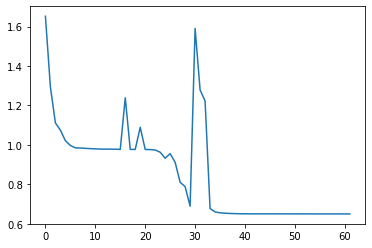

In [27]:
plt.plot(losses)
print(len(losses))

In [9]:
ws = [-0.04618622, -0.92937368,  0.3870059 ,  0.49219175,  2.43983682,
       -0.13393822,  1.91020126,  0.50227641,  0.2499646 ,  1.23536331,
        1.71520408,  0.05776999,  0.41107819]

from test_utils import get_metrics
y_predict, y_tensor, accuracy, [tp, tn, fp, fn] = get_metrics(X_train, qnn1, ws)

Accuracy:  0.7
tp:  68 tn:  72  fp:  31  fn:  29


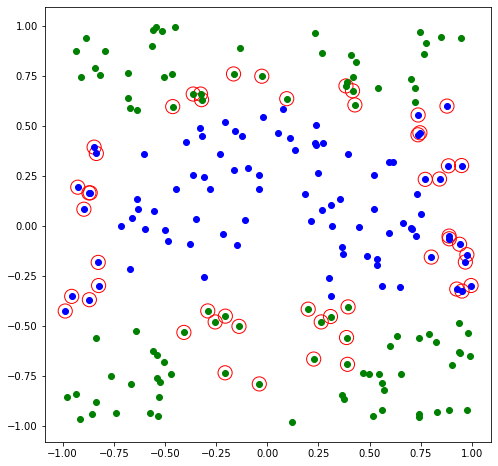

In [24]:
# print('Accuracy:', acc/len(y_tensor))
plt.figure(figsize=(8,8))
for x, y_target, y_ in zip(X_train, y_tensor, y_predict):
    if y_ == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
plt.show()

In [10]:

y_predict, y_tensor, accuracy, [tp, tn, fp, fn] = get_metrics(X_test, qnn1, ws)

Accuracy:  0.736
tp:  729 tn:  743  fp:  274  fn:  254


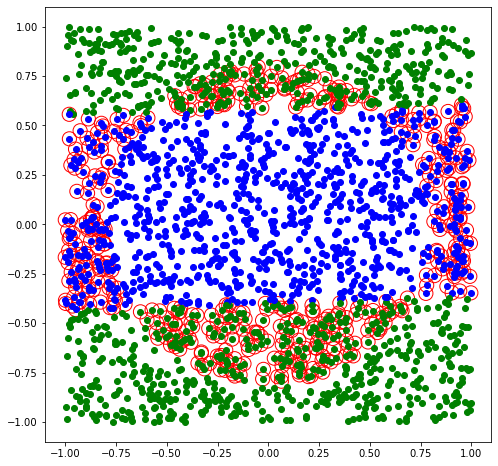

In [26]:
# print('Accuracy:', acc/len(y_tensor))
plt.figure(figsize=(8,8))
for x, y_target, y_ in zip(X_test, y_tensor, y_predict):
    if y_ == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
plt.show()